In [119]:
import pandas as pd
import configparser
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

In [ ]:
# Load credentials from config file
config = configparser.ConfigParser()
config.read('pyalgo.cfg')

consumer_id = config['ssi']['ConsumerID']
consumer_secret = config['ssi']['ConsumerSecret']
private_key = config['ssi']['PrivateKey']

In [77]:
# Step 1: Request access token
def get_access_token(consumer_id, consumer_secret, private_key):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/AccessToken"
    headers = {"Content-Type": "application/json"}
    data = {
        "consumerID": consumer_id,
        "consumerSecret": consumer_secret,
        "privateKey": private_key
    }
    res = requests.post(url, json=data, headers=headers)
    res.raise_for_status()
    response = res.json()

    # Extract access token from response
    if "data" in response and "accessToken" in response["data"]:
        return response["data"]["accessToken"]
    else:
        raise ValueError("Access token not found in response:", response)

# Step 2: Get stock price using access token
def get_stock_price(symbol, token, start_date, end_date):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/DailyStockPrice"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/json"
    }
    params = {
        "Symbol": symbol,
        "FromDate": start_date,
        "ToDate": end_date,
        "Market": "HOSE",
        "PageIndex": "1",
        "PageSize": "50"
    }
    res = requests.get(url, headers=headers, params=params)
    res.raise_for_status()
    return res.json()

In [90]:
# Run the process
token = get_access_token(consumer_id, consumer_secret, private_key)

In [120]:
stock = pd.DataFrame(columns=['TradingDate', 'ClosePrice'])

In [121]:
symb = 'GAS'
date = datetime.today()

for i in range(20):
    end_date = date.strftime("%d/%m/%Y")
    start_date = (date - timedelta(days=30)).strftime("%d/%m/%Y")
    data = get_stock_price(symb, token, start_date, end_date)
    df = pd.DataFrame(data['data'])

    # Ensure correct types
    df['TradingDate'] = pd.to_datetime(df['TradingDate'], dayfirst=True)
    df['ClosePrice'] = pd.to_numeric(df['ClosePrice'], errors='coerce')
    
    df1 = df.loc[df['Symbol'] == symb, ['TradingDate', 'ClosePrice']]

    # Append to master DataFrame
    stock = pd.concat([stock, df1], ignore_index=True)

    # Adjust date back
    date -= timedelta(days=31)

    # Wait before the next request to respect rate limit
    time.sleep(3)  

/tmp/ipykernel_1516/3811047364.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock = pd.concat([stock, df1], ignore_index=True)


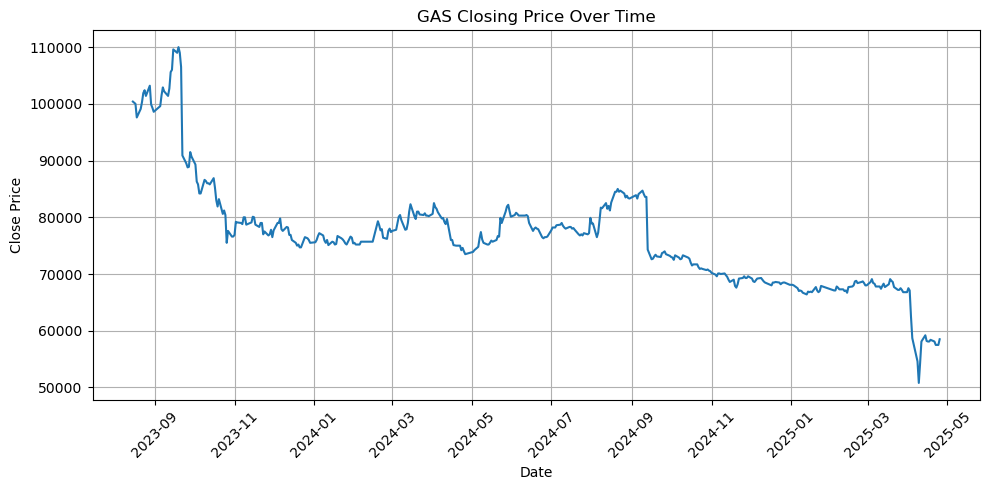

In [123]:
# Sort by trading date
stock = stock.sort_values('TradingDate')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(stock['TradingDate'], stock['ClosePrice'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{symb} Closing Price Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
end_date = datetime.today()
start_date = end_date - timedelta(days=30)

In [118]:
data

{'message': 'API calls quota exceeded! maximum admitted 1 per 1s.',
 'status': 429}